# Sentiment Analysis on News

In [1]:
# Import packages
import pandas as pd
from datetime import datetime
from datetime import date
import xlrd
import numpy as np
import re
# Some functions built by the user
import myfunction as mf
import nltk
nltk.download('stopwords')

In [2]:
# Import dataset - collected in part 1
df_row = pd.read_csv("Headlines_HMUK.csv")
# Get dates and convert them from excel to python dates
excel_dates = np.asarray(df_row["date"])
python_date = []
for j in range(len(excel_dates)):
    python_date.append(date(int(excel_dates[j][:4]),int(excel_dates[j][5:7]),int(excel_dates[j][8:10])))
# Reset index to converted dates
df_row["Dates"] = python_date
df_row = df_row.set_index('Dates')
df_row = df_row.drop(["date"], axis = 1)
df_row.head()

,Unnamed: 0,headline
Dates,,
2020-01-29,0,A tale of two property figures...
2020-01-29,1,UK house price growth 'at 14-month high'
2020-01-29,2,Annual house price growth hits 14-month high
2020-01-25,3,Home sellers risk losing money over quick sales
2020-01-22,4,Super-rich elites making London 'off-limits'


In [3]:
# Create a monthly document based on time etherogenous frequencies headlines
months = []
for t in range(len(python_date)):
    months.append(python_date[t].month)
df = pd.DataFrame()
df["months"] = months
df["document"] = ""
df["Dates"] = python_date
df["Dates"] = df["Dates"] - pd.tseries.offsets.MonthEnd()
# Add the monthly index to the original data
df_row["months"] = months
# merging "daily" headlines into a monthly document
for m in np.unique(months):
    this_month_document = df_row["headline"][df_row["months"]==m]
    df["document"][df["months"]==m] = ' '.join(this_month_document)
df = df.set_index('Dates')
df = df.drop(["months"], axis = 1)
df.drop_duplicates(inplace = True)
df.head()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,document
Dates,
2019-12-31,A tale of two property figures... UK house pri...
2019-11-30,'We just can't afford to live in Dublin' House...
2019-10-31,Final day for Help to Buy Isa applications You...
2019-09-30,'Endless wrangling about Brexit' is hitting ho...
2019-08-31,London Assembly warned of rent control 'conseq...


In [4]:
# Clean text from punctuation and convert to lower case
documents = df["document"]
for i in range(len(documents)):
    # convert to lower case
    documents[i] = documents[i].lower()
    # take out non words
    documents[i] = re.sub(r'\W',' ',documents[i])
    # drop multiple spaces
    documents[i] = re.sub(r'\s+',' ',documents[i])

In [5]:
# Remove stopwords (words that do not add any value) and empty
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')).union([""])
import copy
filtered_documents = copy.deepcopy(documents)
for j in range(len(documents)):
    filtered_documents[j] = [w for w in documents[j].split(" ") if not w in stop_words]

In [6]:
# Split documents into words-components and put them into a list + create a set with all the words (non duplicates)
list_documents = []
total = []
for j in range(len(filtered_documents)):
    this_document = filtered_documents[j]
    list_documents.append(this_document)
    total = set(total).union(set(this_document))

In [7]:
# Count words in each sentence
wordDict = []
# Create a dictionary with all words
Doc_count_word = dict.fromkeys(total, 0)
for j in range(len(filtered_documents)):
    this_wordDict = dict.fromkeys(total, 0) 
    #print(this_wordDict)
    for word in filtered_documents[j]:
        #print(word)
        #print(this_wordDict[word])
        # count how many documents contain the word
        if this_wordDict[word] == 0 : Doc_count_word[word] += 1
        #print(word)
        # plus count how many times the word is contained into the document
        this_wordDict[word] += 1
        #print(this_wordDict[word])
    wordDict.append(this_wordDict) 

In [8]:
# compute the term frequency (n times words / total words)
# https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/
tfAll = []
for j in range(len(wordDict)):
    tfAll.append(mf.computeTF(wordDict[j], list_documents[j]))

In [9]:
# compute Inverse Data Frequency (idf) log10(number of documents on / number of documents containing the word)
idfs = mf.computeIDF(Doc_count_word, len(wordDict))
# Compute TFidf
TFidf = []
for j in range(len(wordDict)):
    TFidf.append(mf.computeTFIDF(tfAll[j], idfs))
df_TFidf = pd.DataFrame(TFidf)

In [10]:
# Import dictionaries (words)
positives_all = list(pd.read_csv("Positive.csv")["both"].dropna())
negatives_all = list(pd.read_csv("Negative.csv")["both"].dropna())
positives_LM = list(pd.read_csv("Positive.csv")["LM"].dropna())
negatives_LM = list(pd.read_csv("Negative.csv")["LM"].dropna())
positives_GI = list(pd.read_csv("Positive.csv")["GI"].dropna())
negatives_GI = list(pd.read_csv("Negative.csv")["GI"].dropna())

In [11]:
# Map words to numbers using the three dictionaries
Doc_word_LM = mf.map_word_to_sent(Doc_count_word, positives_LM, negatives_LM, similarity_check = False)
Doc_word_GI = mf.map_word_to_sent(Doc_count_word, positives_GI, negatives_GI, similarity_check = False)
Doc_word_all = mf.map_word_to_sent(Doc_count_word, positives_all, negatives_all, similarity_check = True)

In [12]:
# Compute scores by weighting the words by the weights obtaining using TFidf
df_scores_GI = copy.deepcopy(df_TFidf)
df_scores_LM = copy.deepcopy(df_TFidf)
df_scores_all = copy.deepcopy(df_TFidf)
for this_key in df_scores_all.keys():
    df_scores_GI[this_key] = df_scores_GI[this_key]*Doc_word_GI[this_key]
    df_scores_LM[this_key] = df_scores_LM[this_key]*Doc_word_LM[this_key]
    df_scores_all[this_key] = df_scores_all[this_key]*Doc_word_all[this_key]

In [13]:
# Put in a unique dataframe
final_df = pd.DataFrame()
final_df["sentiment_index_GI"] = df_scores_GI.sum(axis = 1)
final_df["sentiment_index_LM"] = df_scores_LM.sum(axis = 1)
final_df["sentiment_index_all"] = df_scores_all.sum(axis = 1)
final_df["Dates"] = df.index
final_df = final_df.set_index('Dates')

In [14]:
# Import UK House Prices and convert excel dates to python dates
HP_index = pd.read_csv("UK_HP.csv")
excel_dates = np.asarray(HP_index["date"])
python_date_new = []
for j in range(len(excel_dates)):
    this_date = datetime(*xlrd.xldate_as_tuple(excel_dates[j], 0))
    python_date_new.append(this_date)
# Reset index to converted dates
HP_index["Dates"] = python_date_new
HP_index = HP_index.set_index('Dates')
HP_index = HP_index.drop(["date"], axis = 1)
# Standardize for plot
HP_index["HP Index std"] = (HP_index["HP Index"]-np.mean(HP_index["HP Index"]))/np.std(HP_index["HP Index"])

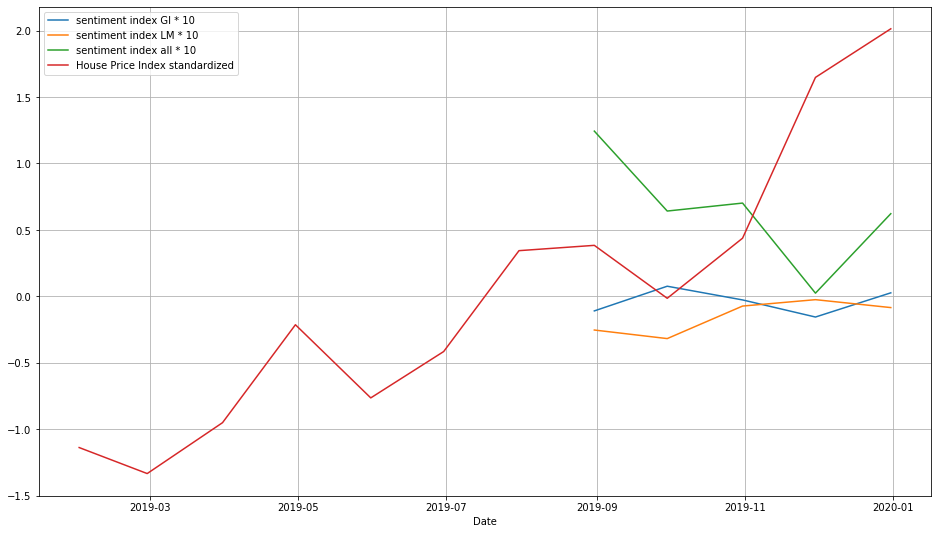

In [16]:
# Plot all of them - if plot does not show, just run this block a second time
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(final_df["sentiment_index_GI"]*10, label = "sentiment index GI * 10")
ax.plot(final_df["sentiment_index_LM"]*10, label = "sentiment index LM * 10")
ax.plot(final_df["sentiment_index_all"]*10, label = "sentiment index all * 10")
ax.plot(HP_index["HP Index std"], label = "House Price Index standardized")
ax.set_xlabel('Date')
ax.legend()
ax.grid()
plt.show()